# TP8 (Student version): recommender systems

## Students:
## Jack Thay - 21201079
## Thierry Ung - 3804472

We can use the following libraries.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import math
import sys
import random
import time
import copy
print(sys.version)

3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


# Part 1: basic recommender system

The purpose of this practical work is to make a basic recommender system, and use it on a Movielens dataset.

## Data preparation

Download from Moodle the rating data extracted from MovieLens.

This file is organised as follows:

<pre>
user_id   movie_id   rating
</pre>

It contains 100836 ratings of 9724 movies by 610 different users. Ratings on MovieLens goes from 0.5 to 5.

### Question 1

Select **randomly** 1% of the ratings (so 1008 ratings). This will be your test set for all of this lab: these ratings are considered as unknown, and we aim at predicting them with the learning set which are the remaining 99% ratings.

Create two files, one containing the learning ratings, another containing the test ratings (please join them to the .ipynb file when sending your work).

In [4]:
# Read the text file into a DataFrame
df = pd.read_csv('rating_list_MovieLens.txt', sep='\t')

# Save the DataFrame to a CSV file
df.to_csv('rating_list_MovieLens.csv', index=False)

In [5]:
# Read the data from the DataFrame
ratings_df = pd.read_csv('rating_list_MovieLens.csv', sep='\s+')

# Set seed for reproducibility
np.random.seed(42)

# Randomly select 1% of the ratings for testing
test_ratings = ratings_df.sample(frac=0.01)

# Create learning set by excluding the test set
learning_ratings = ratings_df.drop(test_ratings.index)

# Save the learning and test sets to separate files
learning_ratings.to_csv('learning_ratings.csv', index=False)
test_ratings.to_csv('test_ratings.csv', index=False)

In [6]:
ratings_df

,user_id,movie_id,score
0,1,0,4.0
1,1,1,4.0
2,1,2,4.0
3,1,3,5.0
4,1,4,5.0
...,...,...,...
100831,610,3120,4.0
100832,610,2035,5.0
100833,610,3121,5.0
100834,610,1392,5.0


In [7]:
learning_ratings

,user_id,movie_id,score
0,1,0,4.0
1,1,1,4.0
2,1,2,4.0
3,1,3,5.0
4,1,4,5.0
...,...,...,...
100831,610,3120,4.0
100832,610,2035,5.0
100833,610,3121,5.0
100834,610,1392,5.0


In [8]:
test_ratings

,user_id,movie_id,score
67037,432,4730,4.5
42175,288,474,3.0
93850,599,2631,3.0
6187,42,194,4.0
12229,75,727,4.0
...,...,...,...
53928,356,149,3.0
51263,331,1129,4.0
17318,111,375,3.5
9591,64,99,2.0


## Benchmark recommender 

The benchmark recommender that you will create works as follows: for a user $u$ and an item $i$, the predicted score is

$$ r^*(u,i) = \overline{r} + ( \overline{r(u)} - \overline{r}) + ( \overline{r(i)} - \overline{r})$$

$\overline{r}$ is the average rating over the whole learning dataset.

$\overline{r(u)}$ is the average rating over the learning dataset of user $u$. In case $u$ is not present in the learning set, consider that $\overline{r(u)} = \overline{r}$.

$\overline{r(i)}$ is the average rating over the learning dataset of item $i$. In case $i$ is not present in the learning set, consider that $\overline{r(i)} = \overline{r}$.

Also if $ r^*(u,i) < 0.5 $ then the predicted score is $0.5$; if $ r^*(u,i) > 5 $ then the predicted score is $5$.

### Question 2

Load the learning data in memory.

Clue: an adequate format for the rest of Part 1 is to create two dictionaries of lists (warning: a dictionary of sets won't work): 

1) keys = user ids , values = list of ratings 

2) keys = item ids , values = list of ratings 

In [9]:
# Read the learning data into a DataFrame, specifying '\t' (tab) as the separator
learning_data = pd.read_csv('learning_ratings.csv', sep='\t')

In [10]:
# If the columns are combined, split them into separate columns
learning_data[['user_id', 'movie_id', 'score']] = learning_data['user_id,movie_id,score'].str.split(',', expand=True)

# Convert the columns to the appropriate data types
learning_data['user_id'] = learning_data['user_id'].astype(int)
learning_data['movie_id'] = learning_data['movie_id'].astype(int)
learning_data['score'] = learning_data['score'].astype(float)

In [11]:
# Create dictionaries of lists
user_ratings_dict = {}
item_ratings_dict = {}

In [12]:
# Populate user_ratings_dict and item_ratings_dict
for _, row in learning_data.iterrows():
    user_id = row['user_id']
    item_id = row['movie_id']
    rating = row['score']
    
    # For user_ratings_dict
    if user_id in user_ratings_dict:
        user_ratings_dict[user_id].append(rating)
    else:
        user_ratings_dict[user_id] = [rating]
    
    # For item_ratings_dict
    if item_id in item_ratings_dict:
        item_ratings_dict[item_id].append(rating)
    else:
        item_ratings_dict[item_id] = [rating]

In [13]:
# Example usage
user_id_example = 1
item_id_example = 4

user_ratings_example = user_ratings_dict.get(user_id_example, [])
item_ratings_example = item_ratings_dict.get(item_id_example, [])

print(f'Ratings for user {user_id_example}: {user_ratings_example}')
print(f'Ratings for item {item_id_example}: {item_ratings_example}')

Ratings for user 1: [4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 4.0, 5.0, 3.0, 3.0, 5.0, 4.0, 4.0, 5.0, 4.0, 3.0, 4.0, 5.0, 4.0, 3.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 2.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 5.0, 4.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 3.0, 3.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 4.0, 2.0, 4.0, 4.0, 5.0, 5.0, 2.0, 4.0, 5.0, 2.0, 5.0, 4.0, 3.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 2.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0,

### Question 3

Create a function which given a user $u$ and an item $i$ returns the value of $r^*(u,i)$ computed on the learning set for the prediction of the rating of user $u$ for item $i$.

In [14]:
def compute_predicted_rating(user_id, item_id, learning_data):
    # Calculate overall average rating
    global_average_rating = learning_data['score'].mean()

    # Calculate average ratings for each user
    user_average_ratings = learning_data.groupby('user_id')['score'].mean().fillna(global_average_rating)

    # Calculate average ratings for each item
    item_average_ratings = learning_data.groupby('movie_id')['score'].mean().fillna(global_average_rating)

    # Get user and item average ratings, default to global average if not present
    user_avg = user_average_ratings.get(user_id, global_average_rating)
    item_avg = item_average_ratings.get(item_id, global_average_rating)

    # Calculate predicted score using the provided formula
    predicted_score = global_average_rating + (user_avg - global_average_rating) + (item_avg - global_average_rating)

    # Apply constraints: predicted score should be between 0.5 and 5
    predicted_score = max(0.5, min(predicted_score, 5))

    return predicted_score

In [15]:
# Example usage
user_id_example = 1
item_id_example = 4

predicted_score_example = compute_predicted_rating(user_id_example, item_id_example, learning_data)

print(f'Predicted score for user {user_id_example} and item {item_id_example}: {predicted_score_example}')

Predicted score for user 1 and item 4: 5


## Evaluation

Now that we have a prediction process, we evaluate its performances on the rating set.

### Question 4

1) For each rating in the **test set**, compute the rating predicted by the function defined above. If the item has not been rated in the learning set or the user has made no rating in the learning set, skip this rating.

To present your results, you can print them in the form:

<pre>
user_id item_id real_rating predicted_rating
</pre>

2) Report the number of pairs of $ (u,i) $ that have not been rated because either the item has note been rated or the user has made no other rating.

In [16]:
# Load learning and test data
test_data = pd.read_csv('test_ratings.csv', sep='\t')

In [17]:
# If the columns are combined, split them into separate columns
test_data[['user_id', 'movie_id', 'score']] = learning_data['user_id,movie_id,score'].str.split(',', expand=True)

# Convert the columns to the appropriate data types
test_data['user_id'] = test_data['user_id'].astype(int)
test_data['movie_id'] = test_data['movie_id'].astype(int)
test_data['score'] = test_data['score'].astype(float)

In [18]:
# Initialize counters for unrated pairs
unrated_pairs_count = 0

In [19]:
# Iterate through the test set
for _, test_row in test_data.iterrows():
    user_id = test_row['user_id']
    item_id = test_row['movie_id']
    real_rating = test_row['score']

    # Check if user and item are present in the learning set
    if user_id in learning_data['user_id'].values and item_id in learning_data['movie_id'].values:
        # Compute predicted rating
        predicted_rating = compute_predicted_rating(user_id, item_id, learning_data)

        # Print the results
        print(f'user_id: {user_id} item_id: {item_id} real_rating: {real_rating} predicted_rating: {predicted_rating}')
    else:
        # Increment the counter for unrated pairs
        unrated_pairs_count += 1

# Report the number of unrated pairs
print(f'\nNumber of unrated pairs: {unrated_pairs_count}')

user_id: 1 item_id: 0 real_rating: 4.0 predicted_rating: 4.776150297103797
user_id: 1 item_id: 1 real_rating: 4.0 predicted_rating: 4.110657339357319
user_id: 1 item_id: 2 real_rating: 4.0 predicted_rating: 4.796300903713754
user_id: 1 item_id: 3 real_rating: 5.0 predicted_rating: 4.845657339357318
user_id: 1 item_id: 4 real_rating: 5.0 predicted_rating: 5
user_id: 1 item_id: 5 real_rating: 3.0 predicted_rating: 4.369748248448228
user_id: 1 item_id: 6 real_rating: 5.0 predicted_rating: 4.643266035009493
user_id: 1 item_id: 7 real_rating: 4.0 predicted_rating: 4.890444573399872
user_id: 1 item_id: 8 real_rating: 5.0 predicted_rating: 4.406111884811864
user_id: 1 item_id: 9 real_rating: 5.0 predicted_rating: 3.7242937029936822
user_id: 1 item_id: 10 real_rating: 5.0 predicted_rating: 4.4212633999633795
user_id: 1 item_id: 11 real_rating: 5.0 predicted_rating: 4.187187951602216
user_id: 1 item_id: 12 real_rating: 3.0 predicted_rating: 4.728304398180848
user_id: 1 item_id: 13 real_rating: 

### Question 5

We remind that the _Root Mean Square Error_, as defined in the course for $K$ predictions is:
$$RMSE (K) = \sqrt{\frac{\sum _{k=1} ^K (r^*(k) - r(k))^2 }{K}} $$
Here $ r^*(k) $ the predicted rating,  $ r(k) $ the real rating.

In recommendation, we are usually interested in recommending the most highly scored items. 

1) After computing $ r^*(k) $ over the whole dataset, order the predictions by decreasing $ r^*(k) $.

2) Then plot the value of the $RMSE (K)$ for $K$ from 1 to the highest possible $K$ value. Comment the curve obtained. 

In [20]:
# Function to compute predicted rating
def compute_predicted_rating_v2(user_id, item_id, user_avg_ratings, item_avg_ratings, global_avg):
    # Get user and item average ratings, default to global average if not present
    user_avg = user_avg_ratings.get(user_id, global_avg)
    item_avg = item_avg_ratings.get(item_id, global_avg)

    # Calculate predicted score using the provided formula
    predicted_score = global_avg + (user_avg - global_avg) + (item_avg - global_avg)

    # Apply constraints: predicted score should be between 0.5 and 5
    predicted_score = max(0.5, min(predicted_score, 5))

    return predicted_score

In [21]:
# Calculate overall average rating for the entire dataset
global_average_rating = learning_data['score'].mean()

In [22]:
# Calculate average ratings for each user and item
user_avg_ratings = learning_data.groupby('user_id')['score'].mean().fillna(global_average_rating).to_dict()
item_avg_ratings = learning_data.groupby('movie_id')['score'].mean().fillna(global_average_rating).to_dict()

In [23]:
# Compute predicted ratings for the whole dataset
learning_data['predicted_rating'] = learning_data.apply(lambda row: compute_predicted_rating_v2(row['user_id'], row['movie_id'], user_avg_ratings, item_avg_ratings, global_average_rating), axis=1)

In [24]:
# Order predictions by decreasing predicted rating
ordered_predictions = learning_data.sort_values(by='predicted_rating', ascending=False)

In [25]:
# Initialize arrays for RMSE values and K values
rmse_values = []
k_values = np.arange(1, len(ordered_predictions) + 1)

In [26]:
# Initialize counters for squared errors and unrated pairs
squared_errors = 0
unrated_pairs_count = 0

In [27]:
# Iterate through the ordered predictions
for _, row in ordered_predictions.iterrows():
    user_id = row['user_id']
    item_id = row['movie_id']
    real_rating = row['score']
    predicted_rating = row['predicted_rating']

    # Check if user and item are present in the learning set
    if user_id in user_avg_ratings and item_id in item_avg_ratings:
        # Increment the counter for unrated pairs
        unrated_pairs_count += 1

        # Calculate squared error
        squared_errors += (predicted_rating - real_rating)**2

        # Calculate RMSE for the current K
        rmse = np.sqrt(squared_errors / unrated_pairs_count)
        rmse_values.append(rmse)

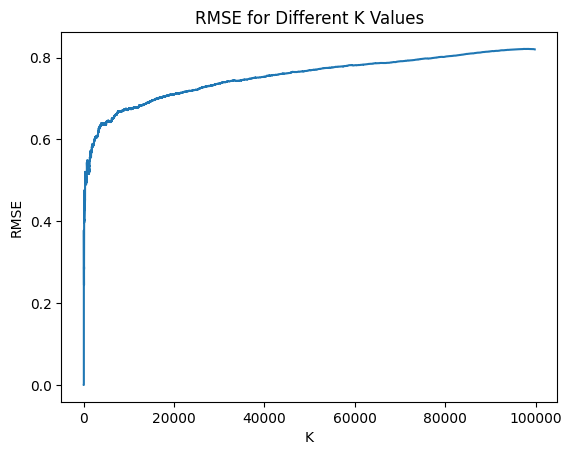

In [28]:
# Plot the RMSE values
plt.plot(k_values, rmse_values)
plt.title('RMSE for Different K Values')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()

### Answer :
A rapidly increasing RMSE could indicate that the predictions for highly scored items are deviating significantly from the real ratings, leading to a higher overall error. 

# Part 2: User-Based Collaborative Filtering (UBCF)

Using the same learning and testing files as in Part1, we aim at building a collaborative filtering method to improve the prediction quality.

For this purpose, we define a distance between users: $ u_1 $ and $ u_2 $ will be close if they rate movies similarly and far away if they rate movies differently.

When predicting a score $ r^*_{CF}(u,i)$, we take into account this distance such that close users have more influence than distant users.

## Loading data

### Question 1

To make a collaborative filtering recommender system, we need more information than in Part1. 

So for Part2, create two dictionnaries of lists from the learning file:

1) keys = user ids , values = list of couples (item , rating) 

2) keys = item ids , values = list of couples (user , rating)

In [40]:
# Load the learning data
learning_data = pd.read_csv('learning_ratings.csv', sep='\t')

In [41]:
# If the columns are combined, split them into separate columns
learning_data[['user_id', 'movie_id', 'score']] = learning_data['user_id,movie_id,score'].str.split(',', expand=True)

# Convert the columns to the appropriate data types
learning_data['user_id'] = learning_data['user_id'].astype(int)
learning_data['movie_id'] = learning_data['movie_id'].astype(int)
learning_data['score'] = learning_data['score'].astype(float)

In [42]:
# Create dictionaries for collaborative filtering
user_item_dict = {}
item_user_dict = {}

In [43]:
# Populate user_item_dict and item_user_dict
for _, row in learning_data.iterrows():
    user_id = row['user_id']
    item_id = row['movie_id']
    rating = row['score']

    # For user_item_dict
    if user_id not in user_item_dict:
        user_item_dict[user_id] = []
    user_item_dict[user_id].append((item_id, rating))

    # For item_user_dict
    if item_id not in item_user_dict:
        item_user_dict[item_id] = []
    item_user_dict[item_id].append((user_id, rating))

In [44]:
# Example usage
user_id_example = 1
print(f"User {user_id_example}'s rated items and ratings: {user_item_dict[user_id_example]}")

item_id_example = 4
print(f"Item {item_id_example}'s rated users and ratings: {item_user_dict[item_id_example]}")

User 1's rated items and ratings: [(0, 4.0), (1, 4.0), (2, 4.0), (3, 5.0), (4, 5.0), (5, 3.0), (6, 5.0), (7, 4.0), (8, 5.0), (9, 5.0), (10, 5.0), (11, 5.0), (12, 3.0), (13, 5.0), (14, 4.0), (15, 5.0), (16, 3.0), (17, 3.0), (18, 5.0), (19, 4.0), (20, 4.0), (21, 5.0), (22, 4.0), (23, 3.0), (24, 4.0), (25, 5.0), (26, 4.0), (27, 3.0), (28, 5.0), (29, 4.0), (30, 4.0), (31, 5.0), (32, 4.0), (33, 4.0), (34, 4.0), (35, 5.0), (36, 5.0), (37, 3.0), (38, 5.0), (39, 3.0), (40, 4.0), (41, 3.0), (42, 3.0), (43, 4.0), (44, 5.0), (45, 5.0), (46, 5.0), (47, 4.0), (48, 5.0), (49, 3.0), (50, 5.0), (51, 5.0), (52, 5.0), (53, 5.0), (54, 3.0), (55, 5.0), (56, 5.0), (57, 4.0), (58, 5.0), (59, 4.0), (60, 5.0), (61, 5.0), (62, 5.0), (63, 4.0), (64, 5.0), (65, 5.0), (66, 4.0), (67, 5.0), (68, 5.0), (69, 5.0), (70, 5.0), (71, 5.0), (72, 4.0), (73, 5.0), (74, 5.0), (75, 4.0), (76, 2.0), (77, 5.0), (78, 5.0), (79, 5.0), (80, 5.0), (81, 5.0), (82, 5.0), (83, 3.0), (84, 4.0), (85, 5.0), (86, 5.0), (88, 5.0), (89, 5.

## Computing distance

The distance between users is defined as follows:

$$ d(u_1,u_2) = \frac{1}{|I_1 \cap I_2|} \sum _{i \in I_1 \cap I_2} (r(u_1,i)  - r(u_2,i))^2 $$

where $ I_1 $ is the set of items rated by $u_1$ and $ I_2 $ is the set of items rated by $u_2$.

### Question 2

The goal of this question is to compute the two elements of the distance between $u_1$ and $u_2$: its numerator $\sum _{i \in I_1 \cap I_2} (r(u_1,i)  - r(u_2,i))^2$ and its denominator $|I_1 \cap I_2|$.

**Warning:** It is the difficult part of the lab work, as you need to make a relatively efficient code. 

1) Create a first matrix $ m_{num}$ of size $611 \times 611$ full of $0$, it will contain $ m_{num}(u_1,u_2) = \sum _{i \in I_1 \cap I_2} (r(u_1,i)  - r(u_2,i))^2$. 
For this purpose, you can use either a list of lists (or a 2-dimensional numpy array if you are familiar with it).

2) Create a second matrix $m_{denom}$ of size $611 \times 611$ full of $0$, it will contain $m_{denom}=|I_1 \cap I_2|$.

3) Go through every item $i$, for every couple of users $(u_1,u_2)$ that have rated $i$, update the values in both matrices $ m_{num}$ and $m_{denom}$.

The third step can take some time, but not too long, I advise you to check (with a counter for instance) that it does not take more than 2 or 3 minutes.

In [45]:
# Initialize matrices
num_users = 611
m_num = np.zeros((num_users, num_users))
m_denom = np.zeros((num_users, num_users))

# Iterate through each item
for _, row in learning_data.iterrows():
    user_id_1 = row['user_id']
    item_id = row['movie_id']
    rating_1 = row['score']

    # Get the list of users who rated the same item
    users_rated_item = item_user_dict.get(item_id, [])

    # Iterate through each user who rated the same item
    for user_id_2, rating_2 in users_rated_item:
        # Update numerator and denominator matrices
        m_num[user_id_1, user_id_2] += (rating_1 - rating_2)**2
        m_denom[user_id_1, user_id_2] += 1

# Check the time taken
print("Matrices computation completed.")

Matrices computation completed.


In [46]:
# Print the first few rows of the matrices for verification
print("Matrix m_num:")
print(m_num[:5, :5])

print("\nMatrix m_denom:")
print(m_denom[:5, :5])

Matrix m_num:
[[  0.     0.     0.     0.     0.  ]
 [  0.     0.     2.    47.   124.  ]
 [  0.     2.     0.     0.    12.25]
 [  0.    47.     0.     0.    20.25]
 [  0.   124.    12.25  20.25   0.  ]]

Matrix m_denom:
[[  0.   0.   0.   0.   0.]
 [  0. 229.   2.   6.  45.]
 [  0.   2.  29.   0.   1.]
 [  0.   6.   0.  37.   1.]
 [  0.  45.   1.   1. 215.]]


## Evaluation

The score predicted is computed in this way

$$ r^*(u,i) = \overline{r} + ( \overline{r(u)} - \overline{r}) + ( \overline{r_u(i)} - \overline{r})$$

You can observe that this score is similar to the benchmark except for the term $ \overline{r_u(i)} $ which is 

$$ \overline{r_u(i)} = \frac{\sum _{v \in U}  \frac{r(v,i)}{d(u,v)}}{\sum _{v \in U} \frac{1}{d(u,v)}} $$

$U$ is the set of users that have rated $i$. 



It is a weighted average of the scores of other users which have rated item $i$, the weight is  $\frac{1}{d(u,v)}$. 

Note that if user $u$ has no common ratings with other users in the network, we consider simply that $ \overline{r_u(i)} = \overline{r(i)} $ (so we get the same result as the benchmark).

### Question 3

For each rating in the **test set**, compute the rating predicted by the function defined above. If the item has not been rated in the learning set or the user has made no rating in the learning set, skip this rating.

To present your results, you can print them in the form:

<pre>
user_id item_id real_rating predicted_rating baseline_or_not
</pre>

<pre> baseline_or_not </pre> indicates if the score predicted is the one of the baseline or the UBCF.

In [48]:
# Function to compute predicted rating for UBCF
def compute_ubcf_predicted_rating(user_id, item_id, learning_data, m_num, m_denom):
    # Calculate overall average rating for the entire dataset
    global_average_rating = learning_data['score'].mean()

    # Calculate average ratings for each user and item
    user_avg_ratings = learning_data.groupby('user_id')['score'].mean().fillna(global_average_rating).to_dict()
    item_avg_ratings = learning_data.groupby('movie_id')['score'].mean().fillna(global_average_rating).to_dict()

    # Check if user and item are present in the learning set
    if user_id in user_avg_ratings and item_id in item_avg_ratings:
        # Get the list of users who rated the same item
        users_rated_item = item_user_dict.get(item_id, [])

        # Initialize variables for numerator and denominator of the weighted average
        weighted_sum = 0
        sum_weights = 0

        # Iterate through each user who rated the same item
        for user_id_other, rating_other in users_rated_item:
            # Skip if the user is the same as the target user
            if user_id_other == user_id:
                continue

            # Calculate the weight based on the distance
            weight = 1 / m_denom[user_id, user_id_other]

            # Update the weighted sum and sum of weights
            weighted_sum += weight * rating_other
            sum_weights += weight

        # Check if there are nonzero weights to avoid division by zero
        if sum_weights != 0:
            # Calculate the predicted score using the weighted average
            predicted_score = global_average_rating + (user_avg_ratings[user_id] - global_average_rating) + (weighted_sum / sum_weights)

            # Apply constraints: predicted score should be between 0.5 and 5
            predicted_score = max(0.5, min(predicted_score, 5))

            return predicted_score
        else:
            # If sum_weights is zero, return baseline prediction
            return compute_predicted_rating(user_id, item_id, learning_data)
    else:
        # If user or item is not present in the learning set, return baseline prediction
        return compute_predicted_rating(user_id, item_id, learning_data)

In [50]:
# Iterate through the test set
for _, test_row in test_data.iterrows():
    user_id = test_row['user_id']
    item_id = test_row['movie_id']
    real_rating = test_row['score']

    # Check if user and item are present in the learning set
    if user_id in learning_data['user_id'].values and item_id in learning_data['movie_id'].values:
        # Compute predicted rating for UBCF
        ubcf_predicted_rating = compute_ubcf_predicted_rating(user_id, item_id, learning_data, m_num, m_denom)

        # Print the results
        print(f'user_id: {user_id} item_id: {item_id} real_rating: {real_rating} predicted_rating: {ubcf_predicted_rating} baseline_or_not: UBCF')
    else:
        # If user or item is not present in the learning set, print baseline prediction
        print(f'user_id: {user_id} item_id: {item_id} real_rating: {real_rating} predicted_rating: {compute_predicted_rating(user_id, item_id, learning_data)} baseline_or_not: Baseline')


user_id: 1 item_id: 0 real_rating: 4.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 1 real_rating: 4.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 2 real_rating: 4.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 3 real_rating: 5.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 4 real_rating: 5.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 5 real_rating: 3.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 6 real_rating: 5.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 7 real_rating: 4.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 8 real_rating: 5.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 9 real_rating: 5.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 10 real_rating: 5.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 11 real_rating: 5.0 predicted_rating: 5 baseline_or_not: UBCF
user_id: 1 item_id: 12 rea

In [64]:
def compute_weigh_average(my_user, my_item, item_set, matrix):
    weighted_average = 0
    sum_weight = 0
    for user in item_set[my_item].keys():
        if matrix[my_user - 1][user - 1] != -1:
            weight = 1
            if matrix[my_user - 1][user - 1] != 0:
                weight = compute_average(my_user, matrix) / matrix[my_user - 1][user - 1]
            sum_weight += weight
            weighted_average += weight * item_set[my_item][user]

    # Check if sum_weight is zero to avoid division by zero
    if sum_weight != 0:
        return weighted_average / sum_weight
    else:
        # Handle the case where sum_weight is zero (you can return a default value)
        return 0.0  # Adjust this as needed
        

def predict_score_improved(my_user, my_item, user_set, item_set, matrix):
    rating_sum, rating_count = 0, 0
    for user in user_set:
        rating_sum += sum(user_set[user].values())
        rating_count += len(user_set[user])
    average_rating = rating_sum / rating_count
    user_rating = sum(user_set[my_user].values()) / len(user_set[my_user]) if my_user in user_set else average_rating
    weighted_average = compute_weigh_average(my_user, my_item, item_set, matrix) if my_item in item_set else average_rating
    return user_rating + weighted_average - average_rating

def evaluate_improved(user_set, item_set, test_file, matrix):
    my_evaluations = []
    with open(test_file, "r") as file:
        for line in file:
            user, item, real_rating = line.split()
            user, item, real_rating = int(user), int(item), float(real_rating)
            if user in user_set and item in item_set:
                predicted_rating = predict_score_improved(user, item, user_set, item_set, matrix)
                #print("{} {} {} {}".format(user, item, real_rating, round(predicted_rating,2)))
                my_evaluations.append((user, item, real_rating, predicted_rating))
    return my_evaluations

In [ ]:
my_evaluations_improved = evaluate_improved(user_set_improved, item_set_improved, "./test_set.txt", matrix)
for user, item, real_rating, predicted_rating in my_evaluations_improved:
    print("{:>7} {:>7} {:>7} {:>7}".format(user, item, real_rating, round(predicted_rating,2)))

### Question 4

We remind that the _Root Mean Square Error_, as defined in the course for $K$ predictions is:
$$RMSE (K) = \sqrt{\frac{\sum _{k=1} ^K (r^*_{CF}(k) - r(k))^2 }{K}} $$
Here $ r^*_{CF}(k) $ the predicted rating,  $ r(k) $ the real rating.

1) After computing $ r*_{CF}(k) $ over the whole dataset, order the predictions by decreasing $ r*_{CF}(k) $.

2) Then plot the value of the $RMSE (K)$ for $K$ from 1 to the highest possible $K$ value. Comment the curve obtained and compare to the one realized in Part 1.

In [59]:
# Iterate through the test set
ubcf_predictions = []  # To store UBCF predictions
for _, test_row in test_data.iterrows():
    user_id = test_row['user_id']
    item_id = test_row['movie_id']
    real_rating = test_row['score']

    # Check if user and item are present in the learning set
    if user_id in learning_data['user_id'].values and item_id in learning_data['movie_id'].values:
        # Compute predicted rating for UBCF
        ubcf_predicted_rating = compute_ubcf_predicted_rating(user_id, item_id, learning_data, m_num, m_denom)
        
        # Store the prediction for later use
        ubcf_predictions.append((ubcf_predicted_rating, real_rating))

In [60]:
# Sort predictions by decreasing UBCF predicted ratings
ubcf_predictions.sort(reverse=True, key=lambda x: x[0])

In [61]:
# Compute RMSE for different values of K
num_predictions = len(ubcf_predictions)
rmse_values = []

In [62]:
for k in range(1, num_predictions + 1):
    # Take the top K predictions
    top_k_predictions = ubcf_predictions[:k]

    # Calculate RMSE for K predictions
    rmse_k = np.sqrt(np.sum([(pred - real) ** 2 for pred, real in top_k_predictions]) / k)
    
    rmse_values.append(rmse_k)

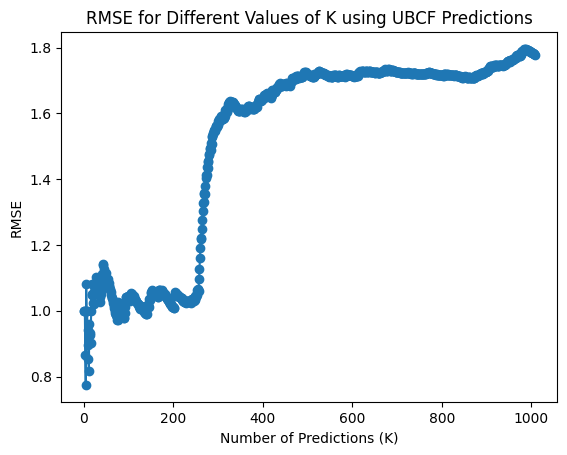

In [63]:
# Plot the RMSE curve
plt.plot(range(1, num_predictions + 1), rmse_values, marker='o')
plt.xlabel('Number of Predictions (K)')
plt.ylabel('RMSE')
plt.title('RMSE for Different Values of K using UBCF Predictions')
plt.show()